# Cell Lineage from Normalized Covariance (CLiNC)

This notebook provides methods to reconstruct a cell type hierarchy from clonal barcoding data, and to detect differnetiation pathways that violate the hierarchy. The code below is sufficient to reproduce the panels from Figure 4 in REF.

### Algorithm overview

The input data is a matrix of barcode counts in across cell types. In principle these counts should represent numbers of cells (as opposed to numbers of sequencing reads). The output is an inferred cell type hierarchy and a list of putative tree violations. The only parameter is the false-discovery rate for detection of conformal symmetry violations (default 5%). The CLiNCs pipeline includes the following steps:

1. Calculate normalized covariance between each pair of cell types
2. Use neighbor-joining to iterative form a cell type hierarchy
3. Identify statistically significant deviations from conformal symmetry
4. Use symmetry violations to infer putative differentiation pathways that violate the hierarchy


### Initialize parameters and imports

In [1]:
import sys
sys.path.append('../')
import clinc.clinc_util as cu

input_data_path = 'barcode_counts.tsv'
output_directory = 'example_output'
symmetry_violation_FDR = 0.05

cu.make_output_dir(output_directory)

### Load input data
Input data should consist of a matrix where each row is a barcoded clone, each column is a cell type, and each entry is a count of cells (the number of cells from the clone in the cell type). Data should be provided as a tab-delimited (tsv) file, with a header consisting of celltype names. Please do not include a label-column (i.e. all columns contain counts data). See example file loaded below. 

Loaded 9301 barcodes in 9 cell types


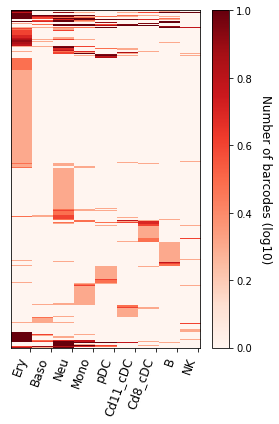

In [2]:
barcode_counts, celltype_names = cu.load_data(input_data_path)
cu.plot_barcode_counts(output_directory, barcode_counts, celltype_names)

### 1. Calculate normalized covariance

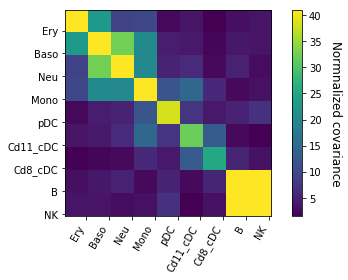

In [3]:
X = cu.get_normalized_covariance(barcode_counts)
cu.plot_normalized_covariance(output_directory, X, celltype_names)

### 2. Use neighbor-joining to iterative form a cell type hierarchy

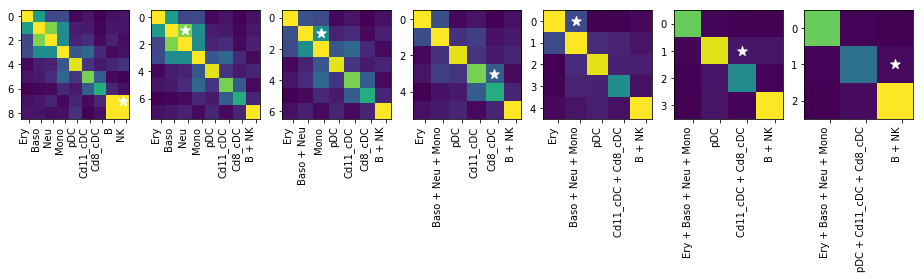

In [4]:
parent_map, node_groups, plot_data = cu.build_hierarchy(barcode_counts)
cu.plot_neighbor_joining(output_directory, node_groups, celltype_names, *plot_data)

In [5]:
cu.print_hierarchy(parent_map, celltype_names)


            /-Cd8_cDC
         /-|
      /-|   \-Cd11_cDC
     |  |
   /-|   \-pDC
  |  |
  |  |   /-NK
  |   \-|
  |      \-B
--|
  |         /-Neu
  |      /-|
  |   /-|   \-Baso
  |  |  |
   \-|   \-Mono
     |
      \-Ery


### 3. Identify statistically significant deviations from conformal symmetry

Detected 15 instances of symmetry violation passing a threshold of 1.9395037458023814 with FDR 0.02


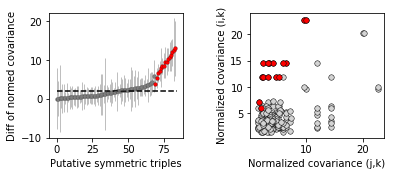

In [6]:
violations, plot_data = cu.detect_symmetry_violations(barcode_counts, parent_map, .02)
cu.plot_violations(output_directory, *plot_data)

### 4. Infer putative differentiation pathways that violate the hierarchy

In [7]:
final_transitions, num_violations_predicted, num_violations_explained, total_explained = cu.detect_cross_tree_transitions(parent_map, violations, barcode_counts.shape[1])

/Users/calebsw/miniconda3/envs/moseq2/lib/python3.6/site-packages/SetCoverPy/setcover.py:241: RuntimeWarning: divide by zero encountered in true_divide
  adjusted_cost = self.c/self.a_csc.dot(np.ones(self.mrows))
/Users/calebsw/miniconda3/envs/moseq2/lib/python3.6/site-packages/SetCoverPy/setcover.py:242: RuntimeWarning: invalid value encountered in multiply
  cost_matrix = adjusted_cost*self.a + np.amax(adjusted_cost)*(~self.a)


This Best solution: UB=4.542363433667782, LB=4.54205117408612, UB1=4.542363433667782, LB1=4.54205117408612
Current Best Solution: UB=4.542363433667782, LB=4.54205117408612, change=0.006874385685380877% @ niters=0
Current Best Solution: UB=4.542363433667782, LB=4.54205117408612, change=0.006874385685380877% @ niters=1
Final Best solution: 4.542363433667782
Took 0.003 minutes to reach current solution.


In [8]:
cu.print_cross_tree_transitions(final_transitions, num_violations_predicted, num_violations_explained, total_explained, len(violations), node_groups, celltype_names)

13 out of 15 symmetry violations can be explained by the following cross-tree transitions:

Explained symmetry violations    Proportion matching    Transition
2                                0.67                   Ery -> Baso
12                               0.52                   pDC+Cd11_cDC+Cd8_cDC -> Mono
